## Build a free app to download and install

- Main source of revenue: in-app ads
- The number of users matters: the more users that see and enage with the ads, the better. 
- Goal of this project: analyse data to help the developers understand what type of apps are likely to attract more users.

### Steps

1. Collect and analyse data about mobile apps available on Google Play and App store
2. Data cleaning: make sure the data we analyze is accurate. 
   - Detect inaccurate data, and correct or remove it.
   - Detect duplicate data, and remove the duplicates.

  Note that we only build apps that are free to download and install, and that are directed toward an English-speaking audience.
   - Remove non-English apps
   - Remove apps that aren't free
   

In [1]:
def explore_data(dataset, start, end, rows_and_columns=False):
    '''analyse dataset information 
    
    Takes in four parameters:
    1) dataset: expected to be a list of lists
    2) start and end: both expected to be integers and represent the starting and the ending indices of a slice from the data set
    3) rows_and_columns: expected to be a Boolean and has False as a default argument
    '''
    dataset_slice = dataset[start:end]
    for row in dataset_slice:
        print(row)
        print('\n') #adds a new (empty) line after each row
        
    if rows_and_columns:
        print('Number of rows:', len(dataset))
        print('Number of columns', len(dataset[0]))

In [2]:
def open_a_file(filename):
    from csv import reader
    opened_file = open(filename, encoding="utf8")

    read_file = reader(opened_file)
    apps_data = list(read_file)
    
    apps_header = apps_data[0]
    apps = apps_data[1:]
    return apps_data, apps_header, apps

Apple_apps_data, ios_header, ios = open_a_file('AppleStore.csv')
Google_apps_data, android_hearder, android = open_a_file('googleplaystore.csv')


Apple_dataset = explore_data(Apple_apps_data, 0, 2, rows_and_columns=True)
Google_dataset = explore_data(Google_apps_data, 0, 2, rows_and_columns=True)

['id', 'track_name', 'size_bytes', 'currency', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'ver', 'cont_rating', 'prime_genre', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic']


['284882215', 'Facebook', '389879808', 'USD', '0.0', '2974676', '212', '3.5', '3.5', '95.0', '4+', 'Social Networking', '37', '1', '29', '1']


Number of rows: 7198
Number of columns 16
['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']


['Photo Editor & Candy Camera & Grid & ScrapBook', 'ART_AND_DESIGN', '4.1', '159', '19M', '10,000+', 'Free', '0', 'Everyone', 'Art & Design', 'January 7, 2018', '1.0.0', '4.0.3 and up']


Number of rows: 10842
Number of columns 13


## Deleting wrong data (Android)

In [3]:
def check_ratings(app_data):
    data_index = []
    for n_data in range(len(app_data)):
        if float(app_data[n_data][2]) > 5:
            data_index.append(n_data)
            return data_index

wrong_data_index = check_ratings(android)  
print(wrong_data_index)

[10472]


In [4]:
print(len(android))
del android[wrong_data_index[0]]
print(len(android))

10841
10840


## Remove duplicate entries (Android)

In [5]:
def count_apps(apps_data):
    import pandas as pd
    import numpy as np

    
    df = pd.DataFrame(apps_data[1:], columns=apps_data[0])
    name_count = df.App.value_counts()
    dup_count = 0
    dups = 0
    for i_count in name_count:
        if i_count > 1:
            dup_count += 1
            dups += i_count - 1
    print('Number of Apps have duplicates: ', dup_count)
    print('\n ')
    print('Total number of duplicate apps: ', dups)
    print('\n')
    print(name_count.index.values[0:5])
    
    return dups
    
#     duplicate_apps = []
#     unique_apps = []

#     for app in android:
#         name = app[0]
#         if name in unique_apps:
#             duplicate_apps.append(name)
#         else:
#             unique_apps.append(name)
    
#     print('Number of duplicate apps: ', len(duplicate_apps))
#     print('\n')
#     print('Examples of duplicate apps: ', len(duplicate_apps[:5]))
    
android_num_dups = count_apps(Google_apps_data)

Number of Apps have duplicates:  798

 
Total number of duplicate apps:  1181


['ROBLOX' 'CBS Sports App - Scores, News, Stats & Watch Live' 'ESPN'
 'Candy Crush Saga' 'Duolingo: Learn Languages Free']


### Remove the duplicates

1. Examine the rows of duplicates and the pattern

In [6]:
for app in android:
    name = app[0]
    if name == 'Instagram':
        print(app)

['Instagram', 'SOCIAL', '4.5', '66577313', 'Varies with device', '1,000,000,000+', 'Free', '0', 'Teen', 'Social', 'July 31, 2018', 'Varies with device', 'Varies with device']
['Instagram', 'SOCIAL', '4.5', '66577446', 'Varies with device', '1,000,000,000+', 'Free', '0', 'Teen', 'Social', 'July 31, 2018', 'Varies with device', 'Varies with device']
['Instagram', 'SOCIAL', '4.5', '66577313', 'Varies with device', '1,000,000,000+', 'Free', '0', 'Teen', 'Social', 'July 31, 2018', 'Varies with device', 'Varies with device']
['Instagram', 'SOCIAL', '4.5', '66509917', 'Varies with device', '1,000,000,000+', 'Free', '0', 'Teen', 'Social', 'July 31, 2018', 'Varies with device', 'Varies with device']


If you examine the rows we printed two cells above for the Instagram app, the main difference happens on the fourth position of each row, which corresponds to the number of reviews. The different numbers show that the data was collected at different times. We can use this to build a criterion for keeping rows. We won't remove rows randomly, but rather we'll keep the rows that have the highest number of reviews because the higher the number of reviews, the more reliable the ratings.

To do that, we will:

2. Create a dictionary where each key is a unique app name, and the value is the highest number of reviews of that app

3. Use the dictionary to create a new data set, which will have only one entry per app (and we only select the apps with the highest number of reviews)


In [7]:
reviews_max = {}

for app in android:
    name = app[0]
    n_reviews = float(app[3])
    if name in reviews_max and reviews_max[name] < n_reviews:
        reviews_max[name] = n_reviews   
        #replace the peviouse item if the previouse one has less reviews, 
        #otherwise do nothing
    elif name not in reviews_max:
        reviews_max[name] = n_reviews

# Check the length
print('Expected length: ', len(android) - android_num_dups)
print('\n')
print('Actual length: ', len(reviews_max))

Expected length:  9659


Actual length:  9659


For the duplicate cases, we'll only keep the entries with the highest number of reviews. In the code cell below:

We start by initializing two empty lists, android_clean and already_added.
We loop through the android data set, and for every iteration:
We isolate the name of the app and the number of reviews.
We add the current row (app) to the android_clean list, and the app name (name) to the already_added list if:
The number of reviews of the current app matches the number of reviews of that app as described in the reviews_max dictionary; and
The name of the app is not already in the already_added list. We need to add this supplementary condition to account for those cases where the highest number of reviews of a duplicate app is the same for more than one entry (for example, the Box app has three entries, and the number of reviews is the same). If we just check for reviews_max[name] == n_reviews, we'll still end up with duplicate entries for some apps.


In [8]:
android_clean = []
android_added = []

for app in android:
    name = app[0]
    n_reviews = float(app[3])
    
    if (reviews_max[name] == n_reviews) and (name not in android_added):
        android_clean.append(app)
        android_added.append(name)

if len(android_clean) == len(reviews_max):
    print('Lengthes macth!')
else:
    print('Somthing went wrong!')

Lengthes macth!


## Removing non-English apps


We're not interested in keeping these kind of apps, so we'll remove them. One way to go about this is to remove each app whose name contains a symbol that is not commonly used in English text — English text usually includes letters from the English alphabet, numbers composed of digits from 0 to 9, punctuation marks (., !, ?, ;, etc.), and other symbols (+, *, /, etc.).

All these characters that are specific to English texts are encoded using the ASCII standard. Each ASCII character has a corresponding number between 0 and 127 associated with it, and we can take advantage of that to build a function that checks an app name and tells us whether it contains non-ASCII characters.

We built this function below, and we use the built-in ord() function to find out the corresponding encoding number of each character.

To minimize the impact of data loss, we'll only remove an app if its name has more than three non-ASCII characters:

In [9]:
def is_english(string):
    non_ascii = 0
    
    for character in string:
        if ord(character) > 127:
            non_ascii += 1
    if non_ascii > 3:
        return False
    else:
        return True


def eng_only(apps_data, app_platform):
    app_clean = []
    #app_added = []
    
    for app in apps_data:
        if app_platform == 'ios':
            name = app[1]
        elif app_platform == 'android':
            name = app[0]
        if is_english(name): #and (name not in app_added):
            app_clean.append(app)
            #app_added.append(name)
    return app_clean

android_english = eng_only(android_clean, 'android')
ios_english = eng_only(ios, 'ios')

print('Android data length: ', len(android_english) )
print('\n')
print('IOS data length: ', len(ios_english))

Android data length:  9614


IOS data length:  6183


## Isolating the free apps

As we mentioned in the introduction, we only build apps that are free to download and install, and our main source of revenue consists of in-app ads. Our data sets contain both free and non-free apps, and we'll need to isolate only the free apps for our analysis. Below, we isolate the free apps for both our data sets.


In [10]:
def free_app(apps_data, app_platform):
    app_final = []
    
    for app in apps_data:
        if app_platform == 'ios':
            price = app[4]
        elif app_platform == 'android':
            price = app[7]
        if price == '0' or price == '0.0':
            app_final.append(app)

    return app_final

android_final = free_app(android_english, 'android')
ios_final = free_app(ios_english, 'ios')

print('Android data length: ', len(android_final))
print('\n')
print('IOS data length: ', len(ios_final))

Android data length:  8864


IOS data length:  3222


## Most common apps by genre

As we mentioned in the introduction, our aim is to determine the kinds of apps that are likely to attract more users because our revenue is highly influenced by the number of people using our apps.

To minimize risks and overhead, our validation strategy for an app idea is comprised of three steps:

Build a minimal Android version of the app, and add it to Google Play.
If the app has a good response from users, we then develop it further.
If the app is profitable after six months, we also build an iOS version of the app and add it to the App Store.
Because our end goal is to add the app on both the App Store and Google Play, we need to find app profiles that are successful on both markets. For instance, a profile that might work well for both markets might be a productivity app that makes use of gamification.

Let's begin the analysis by getting a sense of the most common genres for each market. For this, we'll build a frequency table for the prime_genre column of the App Store data set, and the Genres and Category columns of the Google Play data set.

We'll build two functions we can use to analyze the frequency tables:

1. One function to generate frequency tables that show percentages
2. Another function that we can use to display the percentages in a descending order


Games : 58.16263190564867
Entertainment : 7.883302296710118
Photo & Video : 4.9658597144630665
Education : 3.662321539416512
Social Networking : 3.2898820608317814
Shopping : 2.60707635009311
Utilities : 2.5139664804469275
Sports : 2.1415270018621975
Music : 2.0484171322160147
Health & Fitness : 2.0173805090006205
Productivity : 1.7380509000620732
Lifestyle : 1.5828677839851024
News : 1.3345747982619491
Travel : 1.2414649286157666
Finance : 1.1173184357541899
Weather : 0.8690254500310366
Food & Drink : 0.8069522036002483
Reference : 0.5586592178770949
Business : 0.5276225946617008
Book : 0.4345127250155183
Navigation : 0.186219739292365
Medical : 0.186219739292365
Catalogs : 0.12414649286157665


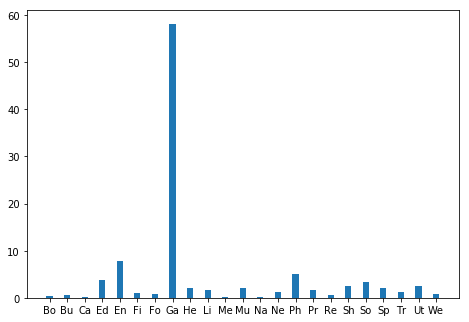

FAMILY : 18.907942238267147
GAME : 9.724729241877256
TOOLS : 8.461191335740072
BUSINESS : 4.591606498194946
LIFESTYLE : 3.9034296028880866
PRODUCTIVITY : 3.892148014440433
FINANCE : 3.7003610108303246
MEDICAL : 3.531137184115524
SPORTS : 3.395758122743682
PERSONALIZATION : 3.3167870036101084
COMMUNICATION : 3.2378158844765346
HEALTH_AND_FITNESS : 3.0798736462093865
PHOTOGRAPHY : 2.944494584837545
NEWS_AND_MAGAZINES : 2.7978339350180503
SOCIAL : 2.6624548736462095
TRAVEL_AND_LOCAL : 2.33528880866426
SHOPPING : 2.2450361010830324
BOOKS_AND_REFERENCE : 2.1435018050541514
DATING : 1.861462093862816
VIDEO_PLAYERS : 1.7937725631768955
MAPS_AND_NAVIGATION : 1.3989169675090252
FOOD_AND_DRINK : 1.2409747292418771
EDUCATION : 1.1620036101083033
ENTERTAINMENT : 0.9589350180505415
LIBRARIES_AND_DEMO : 0.9363718411552346
AUTO_AND_VEHICLES : 0.9250902527075812
HOUSE_AND_HOME : 0.8235559566787004
WEATHER : 0.8009927797833934
EVENTS : 0.7107400722021661
PARENTING : 0.6543321299638989
ART_AND_DESIGN : 

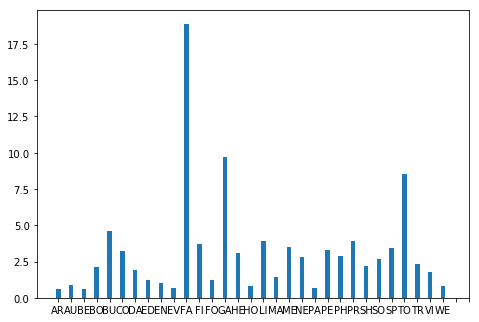

In [13]:


def freq_table(dataset, index):
    table = {}
    
    for row in dataset:
        value = row[index]
        if value in table:
            table[value] += 1
        else:
            table[value] = 1

    table_percentages = {}
    for key in table:
        percentage = (table[key] / len(dataset))*100
        table_percentages[key] = percentage
    
    return table_percentages


def display_table(dataset, index):
    import matplotlib.pyplot as plt
    import numpy as np
    
    table = freq_table(dataset, index)
    table_display = []
    x_axis = []
    y_axis = []
    for key in table:
        key_val_as_tuple = (table[key], key)
        table_display.append(key_val_as_tuple)
        y_axis.append(round(table[key],1))
        x_axis.append(key[:2])
    table_sorted = sorted(table_display, reverse=True)
    
    for entry in table_sorted:
        print(entry[1], ':', entry[0])
        
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x_axis, y_axis, width=0.35)
    ax.set_xticks(np.arange(0,len(x_axis), 1))
    #ax.set_xticklabels('')
    plt.show()
    

display_table(ios_final, -5)
display_table(android_final, 1)
        

## Most popular apps by genre on the app store

One way to find out what genres are the most popular (have the most users) is to calculate the average number of installs for each app genre. For the Google Play data set, we can find this information in the Installs column, but for the App Store data set this information is missing. As a workaround, we'll take the total number of user ratings as a proxy, which we can find in the rating_count_tot app.

Below, we calculate the average number of user ratings per app genre on the App Store:


In [12]:
genres_ios = freq_table(ios_final, -5)

genres_table_display = []
genres_apps = {}

for genre in genres_ios:
    total_ratings = 0
    len_genre = 0
    apps_list = []
    for app in ios_final:
        genre_app = app[-5]
        if genre_app == genre:
            n_ratings = float(app[5])
            total_ratings += n_ratings
            len_genre += 1
            
            apps_list.append((app[1], n_ratings))

        
        genres_apps[genre] = sorted(apps_list, reverse=True, key=lambda x: x[1])
            
    avg_n_ratings = total_ratings / len_genre
    key_val_as_tuple = (avg_n_ratings, genre)
    genres_table_display.append(key_val_as_tuple)
    table_sorted = sorted(genres_table_display, reverse=True)

for entry in table_sorted:
    print(entry[1], ':', entry[0])

def show_rank(genre_apps, key):
    for vals in genre_apps[key]:
        print(vals[0], ':', vals[1])
        
print('\n')
show_rank(genres_apps, 'Navigation')
print('\n')
show_rank(genres_apps,'Reference')

Navigation : 86090.33333333333
Reference : 74942.11111111111
Social Networking : 71548.34905660378
Music : 57326.530303030304
Weather : 52279.892857142855
Book : 39758.5
Food & Drink : 33333.92307692308
Finance : 31467.944444444445
Photo & Video : 28441.54375
Travel : 28243.8
Shopping : 26919.690476190477
Health & Fitness : 23298.015384615384
Sports : 23008.898550724636
Games : 22788.6696905016
News : 21248.023255813954
Productivity : 21028.410714285714
Utilities : 18684.456790123455
Lifestyle : 16485.764705882353
Entertainment : 14029.830708661417
Business : 7491.117647058823
Education : 7003.983050847458
Catalogs : 4004.0
Medical : 612.0


Waze - GPS Navigation, Maps & Real-time Traffic : 345046.0
Google Maps - Navigation & Transit : 154911.0
Geocaching® : 12811.0
CoPilot GPS – Car Navigation & Offline Maps : 3582.0
ImmobilienScout24: Real Estate Search in Germany : 187.0
Railway Route Search : 5.0


Bible : 985920.0
Dictionary.com Dictionary & Thesaurus : 200047.0
Dictionary.com Dic

On average, navigation apps have the highest number of user reviews, but this figure is heavily influenced by Waze and Google Maps, which have close to half a million user reviews together.

The same pattern applies to social networking apps, where the average number is heavily influenced by a few giants like Facebook, Pinterest, Skype, etc. Same applies to music apps, where a few big players like Pandora, Spotify, and Shazam heavily influence the average number.

Our aim is to find popular genres, but navigation, social networking or music apps might seem more popular than they really are. The average number of ratings seem to be skewed by very few apps which have hundreds of thousands of user ratings, while the other apps may struggle to get past the 10,000 threshold. We could get a better picture by removing these extremely popular apps for each genre and then rework the averages, but we'll leave this level of detail for later.

On the other hand, Reference apps have 74,942 user ratings on average, but it's actually the Bible and Dictionary.com which skew up the average rating.


However, this niche seems to show some potential. One thing we could do is take another popular book and turn it into an app where we could add different features besides the raw version of the book. This might include daily quotes from the book, an audio version of the book, quizzes about the book, etc. On top of that, we could also embed a dictionary within the app, so users don't need to exit our app to look up words in an external app.

This idea seems to fit well with the fact that the App Store is dominated by for-fun apps. This suggests the market might be a bit saturated with for-fun apps, which means a practical app might have more of a chance to stand out among the huge number of apps on the App Store.

Other genres that seem popular include weather, book, food and drink, or finance. The book genre seem to overlap a bit with the app idea we described above, but the other genres don't seem too interesting to us:

Weather apps — people generally don't spend too much time in-app, and the chances of making profit from in-app adds are low. Also, getting reliable live weather data may require us to connect our apps to non-free APIs.

Food and drink — examples here include Starbucks, Dunkin' Donuts, McDonald's, etc. So making a popular food and drink app requires actual cooking and a delivery service, which is outside the scope of our company.

Finance apps — these apps involve banking, paying bills, money transfer, etc. Building a finance app requires domain knowledge, and we don't want to hire a finance expert just to build an app.

Now let's analyze the Google Play market a bit.


# Most popular apps by gernr on google play

For the Google Play market, we actually have data about the number of installs, so we should be able to get a clearer picture about genre popularity. However, the install numbers don't seem precise enough — we can see that most values are open-ended (100+, 1,000+, 5,000+, etc.):

1,000,000+ : 15.726534296028879
100,000+ : 11.552346570397113
10,000,000+ : 10.548285198555957
10,000+ : 10.198555956678701
1,000+ : 8.393501805054152
100+ : 6.915613718411552
5,000,000+ : 6.825361010830325
500,000+ : 5.561823104693141
50,000+ : 4.7721119133574
5,000+ : 4.512635379061372
10+ : 3.5424187725631766
500+ : 3.2490974729241873
50,000,000+ : 2.3014440433213
100,000,000+ : 2.1322202166064983
50+ : 1.917870036101083
5+ : 0.78971119133574
1+ : 0.5076714801444043
500,000,000+ : 0.2707581227436823
1,000,000,000+ : 0.22563176895306858
0+ : 0.04512635379061372
0 : 0.01128158844765343


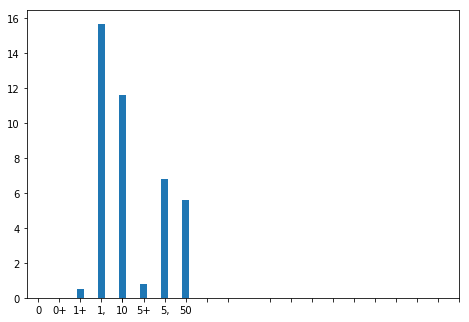

In [14]:
display_table(android_final, 5)

One problem with this data is that is not precise. For instance, we don't know whether an app with 100,000+ installs has 100,000 installs, 200,000, or 350,000. However, we don't need very precise data for our purposes — we only want to get an idea which app genres attract the most users, and we don't need perfect precision with respect to the number of users.

We're going to leave the numbers as they are, which means that we'll consider that an app with 100,000+ installs has 100,000 installs, and an app with 1,000,000+ installs has 1,000,000 installs, and so on.

To perform computations, however, we'll need to convert each install number to float — this means that we need to remove the commas and the plus characters, otherwise the conversion will fail and raise an error. We'll do this directly in the loop below, where we also compute the average number of installs for each genre (category).

In [52]:
categories_android = freq_table(android_final, 1)

category_table_display = []
category_apps = {}
category_length = {}
for category in categories_android:

    total_installs = 0
    len_category = 0
    apps_list = []
    for app in android_final:
        category_app = app[1]
        if category_app == category:
            n_installs = app[5].replace(',', '')
            n_installs = n_installs.replace('+', '')
            n_installs = float(n_installs)
            total_installs += n_installs
            len_category += 1
            
            apps_list.append((app[1], n_installs, app[0]))

        
        category_apps[category] = sorted(apps_list, reverse=True, key=lambda x: x[1])
            
    category_length[category] = len_category
    avg_n_installs = total_installs / len_category
    key_val_as_tuple = (avg_n_installs, category)
    category_table_display.append(key_val_as_tuple)
    category_table_sorted = sorted(category_table_display, reverse=True)

for entry in category_table_sorted:
    print(entry[1], ':', entry[0])
    
    

COMMUNICATION : 38456119.167247385
VIDEO_PLAYERS : 24727872.452830188
SOCIAL : 23253652.127118643
PHOTOGRAPHY : 17840110.40229885
PRODUCTIVITY : 16787331.344927534
GAME : 15588015.603248259
TRAVEL_AND_LOCAL : 13984077.710144928
ENTERTAINMENT : 11640705.88235294
TOOLS : 10801391.298666667
NEWS_AND_MAGAZINES : 9549178.467741935
BOOKS_AND_REFERENCE : 8767811.894736841
SHOPPING : 7036877.311557789
PERSONALIZATION : 5201482.6122448975
WEATHER : 5074486.197183099
HEALTH_AND_FITNESS : 4188821.9853479853
MAPS_AND_NAVIGATION : 4056941.7741935486
FAMILY : 3695641.8198090694
SPORTS : 3638640.1428571427
ART_AND_DESIGN : 1986335.0877192982
FOOD_AND_DRINK : 1924897.7363636363
EDUCATION : 1833495.145631068
BUSINESS : 1712290.1474201474
LIFESTYLE : 1437816.2687861272
FINANCE : 1387692.475609756
HOUSE_AND_HOME : 1331540.5616438356
DATING : 854028.8303030303
COMICS : 817657.2727272727
AUTO_AND_VEHICLES : 647317.8170731707
LIBRARIES_AND_DEMO : 638503.734939759
PARENTING : 542603.6206896552
BEAUTY : 51315

On average, communication apps have the most installs: 38,456,119. This number is heavily skewed up by a few apps that have over one billion installs (WhatsApp, Facebook Messenger, Skype, Google Chrome, Gmail, and Hangouts), and a few others with over 100 and 500 million installs:

In [75]:
def show_rank_android(category_apps, key, cat_len, print_out_over=False, print_out_below=False):
    n_over_100m = 0
    n_below_100m = 0

    for val in category_apps[key]:
        
        if val[1]  >= float(100000000):
            if print_out_over:
                print(val[2], ':', val[1])
            n_over_100m += 1
        elif val[1]  < float(100000000):
            if print_out_below:
                print(val[2], ':', val[1])
            n_below_100m += 1
        
    return 100*n_over_100m/cat_len[key], 100*n_below_100m/cat_len[key]


print('\n')
print(('category', '>=100,000,000 ' , '<100,000,000 ' , 'total_apps '))
for key, val in category_apps.items():
    
    over_100m, below_100m = show_rank_android(category_apps, key, category_length)
    print((key, over_100m, below_100m, category_length[key]))




('category', '>=100,000,000 ', '<100,000,000 ', 'total_apps ')
('ART_AND_DESIGN', 0.0, 100.0, 57)
('AUTO_AND_VEHICLES', 0.0, 100.0, 82)
('BEAUTY', 0.0, 100.0, 53)
('BOOKS_AND_REFERENCE', 2.6315789473684212, 97.36842105263158, 190)
('BUSINESS', 0.4914004914004914, 99.5085995085995, 407)
('COMICS', 0.0, 100.0, 55)
('COMMUNICATION', 9.40766550522648, 90.59233449477352, 287)
('DATING', 0.0, 100.0, 165)
('EDUCATION', 0.0, 100.0, 103)
('ENTERTAINMENT', 5.882352941176471, 94.11764705882354, 85)
('EVENTS', 0.0, 100.0, 63)
('FINANCE', 0.3048780487804878, 99.6951219512195, 328)
('FOOD_AND_DRINK', 0.0, 100.0, 110)
('HEALTH_AND_FITNESS', 0.7326007326007326, 99.26739926739927, 273)
('HOUSE_AND_HOME', 0.0, 100.0, 73)
('LIBRARIES_AND_DEMO', 0.0, 100.0, 83)
('LIFESTYLE', 0.28901734104046245, 99.71098265895954, 346)
('GAME', 6.844547563805104, 93.15545243619489, 862)
('FAMILY', 0.8353221957040573, 99.16467780429595, 1676)
('MEDICAL', 0.0, 100.0, 313)
('SOCIAL', 5.508474576271187, 94.49152542372882, 2

In [76]:
print('\n')
over_100m_communication, below_100m_communication = show_rank_android(category_apps, 'COMMUNICATION', category_length, True)
print('>=100,000,000: ' , over_100m_communication)
print('<100,000,000: ' , below_100m_communication)
print('total_apps: ', category_length['COMMUNICATION'])
print('\n')
over_100m_games, below_100m_games = show_rank_android(category_apps, 'VIDEO_PLAYERS', category_length, True)
print('>=100,000,000: ' , over_100m_games)
print('<100,000,000: ' , below_100m_games)
print('total_apps: ', category_length['VIDEO_PLAYERS'])
print('\n')
over_100m_book, below_100m_book = show_rank_android(category_apps, 'BOOKS_AND_REFERENCE', category_length,True)
print('>=100,000,000: ' , over_100m_book)
print('<100,000,000: ' , below_100m_book)
print('total_apps: ', category_length['BOOKS_AND_REFERENCE'])



WhatsApp Messenger : 1000000000.0
Messenger – Text and Video Chat for Free : 1000000000.0
Skype - free IM & video calls : 1000000000.0
Google Chrome: Fast & Secure : 1000000000.0
Gmail : 1000000000.0
Hangouts : 1000000000.0
Google Duo - High Quality Video Calls : 500000000.0
imo free video calls and chat : 500000000.0
LINE: Free Calls & Messages : 500000000.0
UC Browser - Fast Download Private & Secure : 500000000.0
Viber Messenger : 500000000.0
imo beta free calls and text : 100000000.0
Android Messages : 100000000.0
Who : 100000000.0
GO SMS Pro - Messenger, Free Themes, Emoji : 100000000.0
Firefox Browser fast & private : 100000000.0
Messenger Lite: Free Calls & Messages : 100000000.0
Kik : 100000000.0
KakaoTalk: Free Calls & Text : 100000000.0
Opera Mini - fast web browser : 100000000.0
Opera Browser: Fast and Secure : 100000000.0
Telegram : 100000000.0
Truecaller: Caller ID, SMS spam blocking & Dialer : 100000000.0
UC Browser Mini -Tiny Fast Private & Secure : 100000000.0
WeChat 

We see the same pattern for the video players category, which is the runner-up with 24,727,872 installs. The market is dominated by apps like Youtube, Google Play Movies & TV, or MX Player. The pattern is repeated for social apps (where we have giants like Facebook, Instagram, Google+, etc.), photography apps (Google Photos and other popular photo editors), or productivity apps (Microsoft Word, Dropbox, Google Calendar, Evernote, etc.).

Again, the main concern is that these app genres might seem more popular than they really are. Moreover, these niches seem to be dominated by a few giants who are hard to compete against.

The game genre seems pretty popular, but previously we found out this part of the market seems a bit saturated, so we'd like to come up with a different app recommendation if possible.

The books and reference genre looks fairly popular as well, with an average number of installs of 8,767,811. It's interesting to explore this in more depth, since we found this genre has some potential to work well on the App Store, and our aim is to recommend an app genre that shows potential for being profitable on both the App Store and Google Play.

And it seems there's still a small number of extremely popular apps that skew the average. Therefore, this market still shows potential.


In [77]:
over_100m_book, below_100m_book = show_rank_android(category_apps, 'BOOKS_AND_REFERENCE', category_length,False, True)
print('>=100,000,000: ' , over_100m_book)
print('<100,000,000: ' , below_100m_book)
print('total_apps: ', category_length['BOOKS_AND_REFERENCE'])

Wikipedia : 10000000.0
Cool Reader : 10000000.0
FBReader: Favorite Book Reader : 10000000.0
HTC Help : 10000000.0
Moon+ Reader : 10000000.0
Aldiko Book Reader : 10000000.0
Al-Quran (Free) : 10000000.0
Al Quran Indonesia : 10000000.0
Al'Quran Bahasa Indonesia : 10000000.0
Quran for Android : 10000000.0
Dictionary.com: Find Definitions for English Words : 10000000.0
English Dictionary - Offline : 10000000.0
NOOK: Read eBooks & Magazines : 10000000.0
Dictionary : 10000000.0
Spanish English Translator : 10000000.0
Dictionary - Merriam-Webster : 10000000.0
JW Library : 10000000.0
Oxford Dictionary of English : Free : 10000000.0
English Hindi Dictionary : 10000000.0
AlReader -any text book reader : 5000000.0
Ebook Reader : 5000000.0
Read books online : 5000000.0
Ancestry : 5000000.0
Dictionary - WordWeb : 5000000.0
50000 Free eBooks & Free AudioBooks : 5000000.0
Al Quran : EAlim - Translations & MP3 Offline : 5000000.0
Bible KJV : 5000000.0
English to Hindi Dictionary : 5000000.0
Book store 


This niche seems to be dominated by software for processing and reading ebooks, as well as various collections of libraries and dictionaries, so it's probably not a good idea to build similar apps since there'll be some significant competition.

We also notice there are quite a few apps built around the book Quran, which suggests that building an app around a popular book can be profitable. It seems that taking a popular book (perhaps a more recent book) and turning it into an app could be profitable for both the Google Play and the App Store markets.

However, it looks like the market is already full of libraries, so we need to add some special features besides the raw version of the book. This might include daily quotes from the book, an audio version of the book, quizzes on the book, a forum where people can discuss the book, etc.

# Conclusion

In this project, we analyzed data about the App Store and Google Play mobile apps with the goal of recommending an app profile that can be profitable for both markets.

We concluded that taking a popular book (perhaps a more recent book) and turning it into an app could be profitable for both the Google Play and the App Store markets. The markets are already full of libraries, so we need to add some special features besides the raw version of the book. This might include daily quotes from the book, an audio version of the book, quizzes on the book, a forum where people can discuss the book, etc.